# Titanic  

In [1]:
# 机器学习 - ”举一反三“
# 根据建模过程：监督学习，无监督学习和强化学习
# 根据目标，
# 分类(classification)
# 回归(regression)
# 聚类(clustering) - 无监督
# 降维(dimensionality reduction)

# 分类与回归：预测模型，给定输入，得到输出。
# 区别：对于预测结果，如果期望是离散的，那么是分类，如果是连续的，那么是回归。
# 主流算法：
# LR（线性回归）
# Ensemble（集成学习）
# Decision Tree(决策树)
# Random Forest(随机森林)：随机森林可以看作一个决策树的集合。
# SVM（Support Vector Machine - 支持向量机）：分类算法，期望用一条线分隔不同类数据点
# SGD（随机梯度下降）
# GP(高斯过程)：
# Naive Bayes（朴素贝叶斯）：基于概率论的贝叶斯定理，适用于特征之间的相互独立的场景
# KNN（K nearest neighbour - K近邻）：如果一个样本在特征空间中最邻近的样本中的大多数属于某一个类别，
# 则该样本也属于这个类别。）

# 聚类：无监督学习
# 没有标签，不知道预测结果的范围
# 主流算法：
# K-means（K-均值）：n 个点（可以是样本的一次观察或一个实例）划分到 k 个集群（cluster）
#                 使得每个点都属于离他最近的均值（即聚类中心，centroid）对应的集群。
# GMM（高斯混合模型）

# 降维：
# 特征维度过高会增加训练的负担和存储空间，降维期望去除特征的冗余，用更少的维数表示特征
# 主流算法：PCA(主成分分析)

# Titanic案例
# 是监督学习问题：有Label = ‘Survived’
# 是分类问题：目标变量‘Survived’是离散的（0，1）


## 环境配置

In [2]:
import sys
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import IPython
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

#忽略警号
import warnings
warnings.filterwarnings("ignore")

# 禁用科学计数法+保留两位小数
pd.set_option('display.float_format',lambda x : '%.2f' % x)


import random
import time

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
# naive_bayes 朴素贝叶斯模型（分类）
# sklearn.svm 支持向量机（分类）
# neighbors 最近邻搜索 （分类）
# ensemble 集成学习（分类）
# discriminant_analysis 判别分析（分类）
# linear_model 回归模型
# gaussian_process 高斯过程（回归）

## 数据导入 

In [3]:
data_raw = pd.read_csv('train.csv')  # 训练集
data_val = pd.read_csv('test.csv')  # 测试集

data1 = data_raw.copy(deep=True)
data_cleaner = [data1, data_val]

data_raw.info()
data_raw.sample(10)

# SibSp => 堂兄弟/妹个数
# Parch => 父母与小孩个数
# Fare => 票价
# Cabin => 客舱号
# Embarked => 事发所在甲板

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.38,B57 B59 B63 B66,C
778,779,0,3,"Kilgannon, Mr. Thomas J",male,nan,0,0,36865,7.74,NaN,Q
553,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.00,0,0,2620,7.22,NaN,C
131,132,0,3,"Coelho, Mr. Domingos Fernandeo",male,20.00,0,0,SOTON/O.Q. 3101307,7.05,NaN,S
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.00,0,0,250646,13.00,NaN,S
392,393,0,3,"Gustafsson, Mr. Johan Birger",male,28.00,2,0,3101277,7.92,NaN,S
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,nan,0,1,113505,55.00,E33,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.07,NaN,C
518,519,1,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.00,1,0,226875,26.00,NaN,S
215,216,1,1,"Newell, Miss. Madeleine",female,31.00,1,0,35273,113.28,D36,C


## 数据预处理 

In [4]:
# 数据清洗的4C原则
# 
# 校正 correcting - 明显不合理的数据（年龄>800）
# 填充 completing - 缺失值填充 - 估算/删除 - 3m - mean/median/mode 
# 创建 creating - 创建新的特征
# 转换 converting - 数据格式转换 - obj类型将被转换为哑变量（sex - 0/1）

### 缺失值处理

In [5]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-" * 10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-" * 10)
data_raw.describe(include='all')

for dataset in data_cleaner:
    # complete missing age with median 中位数
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

    # complete embarked with mode 众数
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)

    # complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

# 删除部分数据：Cabin缺失值过多， ID/Ticket票号 无统计意义
drop_column = ['PassengerId', 'Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace=True)

print(data1.isnull().sum())
print("-" * 10)
print(data_val.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------
Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


### 新增特征列

In [6]:
for dataset in data_cleaner:
    # Discrete variables
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1  # initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0  # now update to no/0 if family size is greater than 1

    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    # split(',', expand=True) 一列分多列

    # Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    # Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    # 将连续数据分装到几个区间（桶）里
    # cut: 按连续数据的大小分到各个桶里，每个桶里样本量可能不同，但是，每个桶相当于一个等长的区间，即：以数据的最大和最小为边界，等分成p个桶。
    # qcout: 与cut主要的区别就是每个桶里的样本数量是一定的。
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    

    # Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

    # import sklearn.preprocessing as pre_processing  # 此处有人使用Scaling放缩方法处理变化幅度较大数据
    # scalar = pre_processing.StandardScaler()
    # age_scale = scalar.fit(data1['Age'].values.reshape(-1,1))
    # data1['age_sacled'] = scalar.fit_transform(data1['Age'].values.reshape(-1,1), age_scale)


# cleanup rare title names
print(data1['Title'].value_counts())
stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)  # this will create a true false series with title name as index

# apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
# Misc. 杂项
print(data1['Title'].value_counts())
print("-" * 10)

# preview data again
data1.info()
data_val.info()
data1.sample(10)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Don               1
Ms                1
Mme               1
Sir               1
Capt              1
the Countess      1
Lady              1
Jonkheer          1
Name: Title, dtype: int64
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
55,1,1,"Woolner, Mr. Hugh",male,28.00,0,0,35.50,S,1,1,Mr,"(31.0, 512.329]","(16.0, 32.0]"
402,0,3,"Jussila, Miss. Mari Aina",female,21.00,1,0,9.82,S,2,0,Miss,"(7.91, 14.454]","(16.0, 32.0]"
287,0,3,"Naidenoff, Mr. Penko",male,22.00,0,0,7.90,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
385,0,2,"Davies, Mr. Charles Henry",male,18.00,0,0,73.50,S,1,1,Mr,"(31.0, 512.329]","(16.0, 32.0]"
782,0,1,"Long, Mr. Milton Clyde",male,29.00,0,0,30.00,S,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
274,1,3,"Healy, Miss. Hanora ""Nora""",female,28.00,0,0,7.75,Q,1,1,Miss,"(-0.001, 7.91]","(16.0, 32.0]"
575,0,3,"Patchett, Mr. George",male,19.00,0,0,14.50,S,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
330,1,3,"McCoy, Miss. Agnes",female,28.00,2,0,23.25,Q,3,0,Miss,"(14.454, 31.0]","(16.0, 32.0]"
78,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,29.00,S,3,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
608,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.00,1,2,41.58,C,4,0,Mrs,"(31.0, 512.329]","(16.0, 32.0]"


### 特征编码

In [7]:
# 在现实中，许多标签和特征在数据收集完毕的时候，都不是以数字来表现的。
# 比如说，学历的取值可以是[“小学”，“初中”，“高中”，“大学”]，付费方式可能包含[“支付宝”，“现金”，“微信”]等等。
# 在这种情况下，为了让数据适应算法和库，我们必须将数据进行编码，即是说，将文字型数据转换为数值型。
# sklearn.preprocessing.OrdinalEncoder()  # 整数编码 可用于2d array - 存在大小关系，数值大小有顺序
# sklearn.preprocessing.LabelEncoder()  # 只能用于1d array - 
# 实际上，上述两种方法非常接近。应用中，Label能做的Ordinal都能做.
# 但Ordinal还可以处理存在大小关系（冷，一般，温暖，热）的特征，并且同时处理多个特征（2D）。
# sklearn.preprocessing.OneHotEncoder()  # 独热编码 - 不存在大小关系的属性 - 哑特征(dummy feature)
# Pandas.get_dummies()  # 也是独热编码 经常使用
# 前两者都是数字编码，

# import pandas as pd
# from sklearn.preprocessing import LabelEncoder  # 将分类转换为分类数值
# y = pd.DataFrame(['yes','yes','es','z','o','no','no','no'],columns=['target'])
# label = LabelEncoder().fit_transform(y)
# label

# import pandas as pd
# from sklearn.preprocessing import OrdinalEncoder  
# # 把所有的相同类别的特征编码成同一个值，例如女=0，男=1，狗狗=2，
# # 所以最后编码的特征值是在[0, n-1]之间的整数。
# X = pd.DataFrame([['male','high'],
#                   ['female','high'],
#                   ['male','low'],
#                   ['female','medium'],
#                   ['female','medium'],
#                   ['female','low']],
#                  columns=['sex','income'])         
# X = OrdinalEncoder().fit_transform(X)


# 一个属性如果有N个可取值，它就可以扩充为N个属性，
# 每个样本的这N个属性中，只能有一个为1，表示该样本的该属性属于这个类别，其余扩展属性都为0

# import sklearn.preprocessing as pre_processing
# import numpy as np
 
# label=pre_processing.LabelEncoder()
# labels=label.fit_transform(['中国','美国','法国','德国', '中国', '法国'])
# labels=np.array(labels).reshape(len(labels),1) #先将X组织成（sample，feature）的格式
# onehot=pre_processing.OneHotEncoder()
# onehot_label=onehot.fit_transform(labels)
# onehot_label.toarray()

# # 利用Pandas.get_dummies进行one-hot式特征编码
# df = pd.DataFrame([  
#             ['green' , 'A'],   
#             ['red'   , 'B'],   
#             ['blue'  , 'A']])  
# df.columns = ['color',  'class'] 
# pd.get_dummies(df)



# df = pd.DataFrame(['中国','美国','法国','德国', '中国', '法国'])
# pd.get_dummies(df)


In [8]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
oe = OrdinalEncoder()
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
#     两种写法有什么区别？参考前文，在此处，没有区别，因为性别是没有大小关系的。
#     dataset['Sex_Code'] = label.fit_transform(dataset['Sex'].values.reshape(-1, 1))1
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

### 特征选取 

In [9]:
#define y variable aka target/outcome
Target = ['Survived']

# data1 训练集
#define x variables for original features aka feature selection
# data1_x 主要用于描述性统计及可视化分析
# data1_x_calc用于算法计算，仍未移除连续变量，如Age
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
# 此时并非使用独热编码

# data1_x_calc在后文作为训练集和测试集的列
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')
# print(data1[data1_x].info())

        
#define x variables for original w/bin features to remove continuous variables
# 真正用于算法的 特征列表
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])  # 独热编码
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')
data1

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,7.25,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,71.28,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,7.92,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,53.10,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.00,0,0,8.05,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,13.00,S,1,1,Misc,"(7.91, 14.454]","(16.0, 32.0]",1,2,1,1,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,30.00,S,1,1,Miss,"(14.454, 31.0]","(16.0, 32.0]",0,2,2,1,2
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.00,1,2,23.45,S,4,0,Miss,"(14.454, 31.0]","(16.0, 32.0]",0,2,2,1,2
889,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,30.00,C,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]",1,0,3,1,2


### 检查数据集

In [10]:
print('Train columns with null values: \n', data1.isnull().sum())  # 空值检查
print("-"*10)
print (data1.info())
print("-"*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())  # 基本信息
print("-"*10)

data_raw.describe(include = 'all')  # 描述统计

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 no

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.00,891.00,891.00,891,891,714.00,891.00,891.00,891,891.00,204,889
unique,nan,nan,nan,891,2,nan,nan,nan,681,nan,147,3
top,nan,nan,nan,"Fleming, Miss. Margaret",male,nan,nan,nan,1601,nan,B96 B98,S
freq,nan,nan,nan,1,577,nan,nan,nan,7,nan,4,644
mean,446.00,0.38,2.31,NaN,NaN,29.70,0.52,0.38,NaN,32.20,NaN,NaN
std,257.35,0.49,0.84,NaN,NaN,14.53,1.10,0.81,NaN,49.69,NaN,NaN
min,1.00,0.00,1.00,NaN,NaN,0.42,0.00,0.00,NaN,0.00,NaN,NaN
25%,223.50,0.00,2.00,NaN,NaN,20.12,0.00,0.00,NaN,7.91,NaN,NaN
50%,446.00,0.00,3.00,NaN,NaN,28.00,0.00,0.00,NaN,14.45,NaN,NaN
75%,668.50,1.00,3.00,NaN,NaN,38.00,1.00,0.00,NaN,31.00,NaN,NaN


### 划分数据集

In [11]:

# model_selection.train_test_split
# 随机划分训练集和测试集， 常用于交叉验证
# test_size 默认值0.25 即使用四分之一的随机样本数据作为测试集
# 
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

# train1_y, test1_y
print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x,train1_x_dummy
# 注意此时tran1_x/test1_x中没有采用独热编码，train1_x_dummy,test1_x_dummy才是独热编码

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


(     Sex_Code  Pclass  Embarked_Code  Title_Code  SibSp  Parch   Age  Fare
 105         1       3              2           3      0      0 28.00  7.90
 68          0       3              2           2      4      2 17.00  7.92
 253         1       3              2           3      1      0 30.00 16.10
 320         1       3              2           3      0      0 22.00  7.25
 706         0       2              2           4      0      0 45.00 13.50
 ..        ...     ...            ...         ...    ...    ...   ...   ...
 835         0       1              0           2      1      1 39.00 83.16
 192         0       3              2           2      1      0 19.00  7.85
 629         1       3              1           3      0      0 28.00  7.73
 559         0       3              2           4      1      0 36.00 17.40
 684         1       2              2           3      1      1 60.00 39.00
 
 [668 rows x 8 columns],
      Pclass  SibSp  Parch   Age  Fare  FamilySize  IsAlone  

## 探索性分析 

### 目标特征分布

In [12]:
for x in data1_x:
#     data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 
#                'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
#     Taget = ['Survived']
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)  # 统计生还率在各个指标上的分布
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())  # groupby对象的聚合函数自动选取Numeric对象
        print('-'*10, '\n')
        
print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female      0.74
1    male      0.19
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1      0.63
1       2      0.47
2       3      0.24
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C      0.55
1        Q      0.39
2        S      0.34
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master      0.57
1    Misc      0.44
2    Miss      0.70
3      Mr      0.16
4     Mrs      0.79
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0      0.35
1      1      0.54
2      2      0.46
3      3      0.25
4      4      0.17
5      5      0.00
6      8      0.00
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0      0.34
1      1      0.55
2      2      0.50
3      3      0.60
4      4      0.00
5      5      0.20
6      6      0.00
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1      0.30
1 

### 可视化

#### plt: 箱线图 + 直方图 

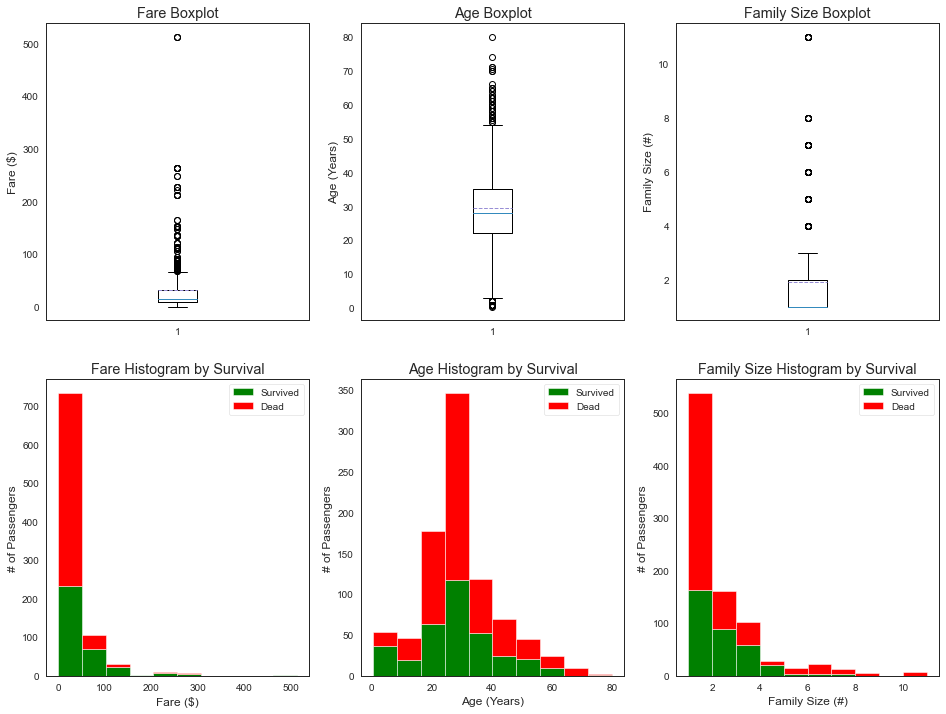

In [13]:
plt.figure(figsize=[16,12])  # 打开一张画布

# 箱线图 showmeans: 显示均值 meanline：均值线  

plt.subplot(231)  # 两行三列共六个子图，它排在第一个
plt.boxplot(data1['Fare'], showmeans = True, meanline = True)  
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

# 直方图 x = 表示同一个区间显示几种数据，这里传入两个数组，并对应color绿蓝两种
# stacked = True: 两组数据叠摞，或False：并列
plt.subplot(234)
plt.hist(x =[data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()  # legend() 显示图例

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

#### sns: 柱状图 + 点图

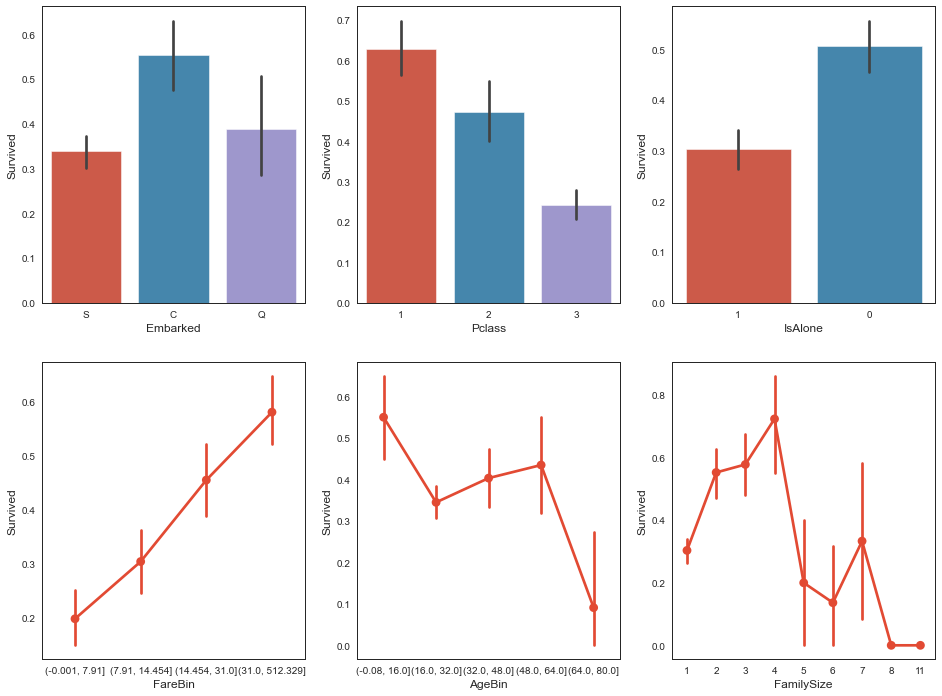

In [14]:
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

# seabon as sns
# x y 均为dataframe的列名

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

#### sns: 小提琴图 + 箱线图

Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

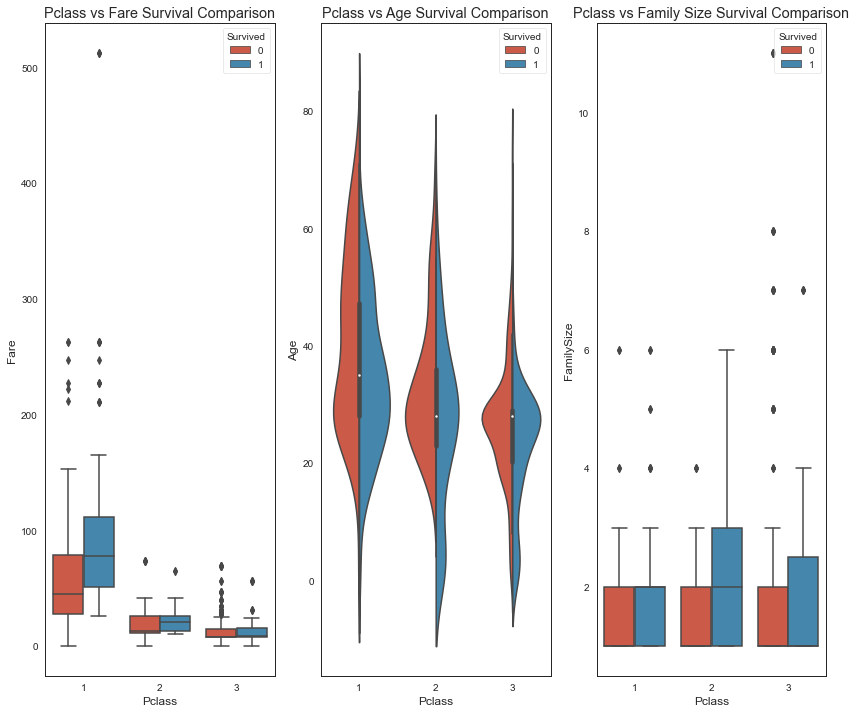

In [15]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

# hue:指定某一用于分类的列
sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

# split:是否拆分，True:画出每个分类的一半小提琴
sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')


#### sns: 柱状图 - Sex

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

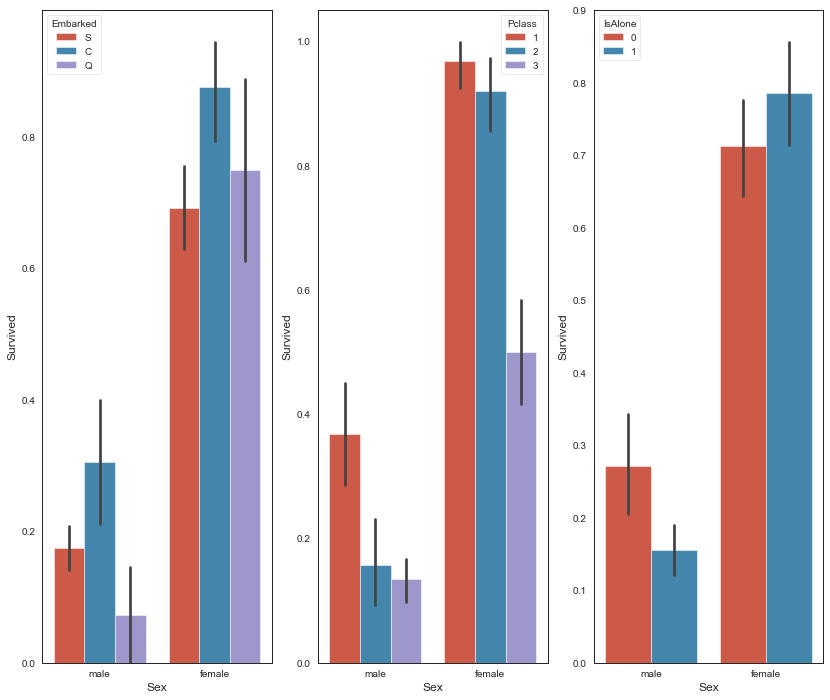

In [16]:
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

#### sns: 点图 - FamilySize / Pclass 

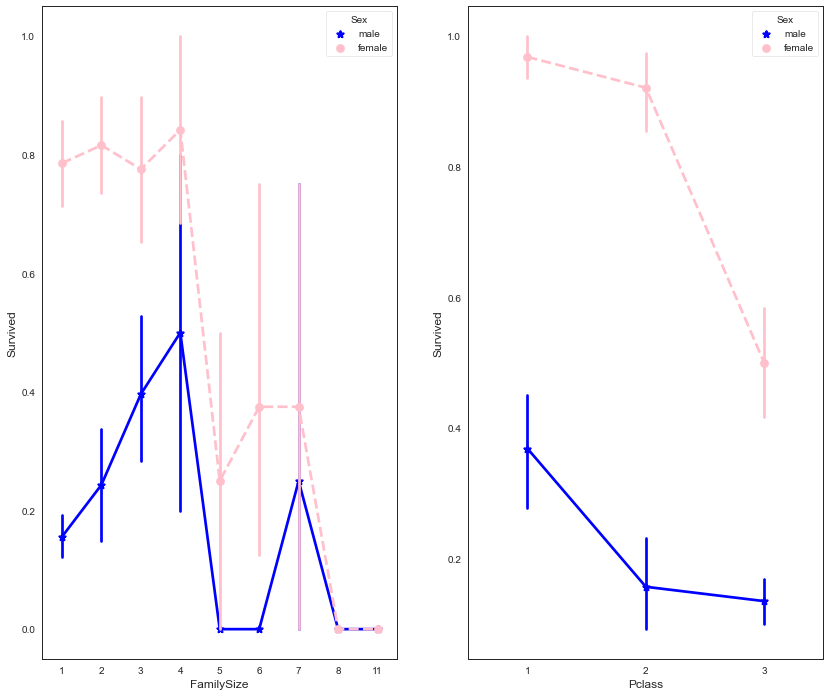

In [17]:
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#how does family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

#### sns: FacetGrid - 点图 - Embarked

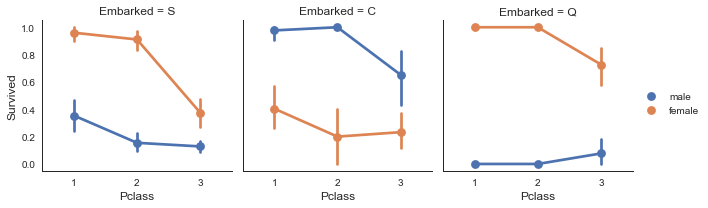

In [18]:
# FaceGrid() - “映射”，做出某一特征所有值（此处为Embarked）的多个子图
# 它的基本工作流程是FacetGrid使用数据集和用于构造网格的变量初始化对象。
# 然后，可以通过调用FacetGrid.map()或将一个或多个绘图函数应用于每个子集 FacetGrid.map_dataframe()，
# 最后，可以使用其他修改参数的方法调整绘图。
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
e.add_legend()

#### sns: FacetGrid -  核密度图 - Age

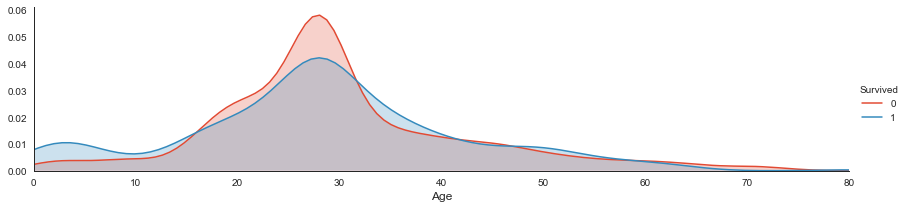

In [19]:
a = sns.FacetGrid( data1, hue = 'Survived', aspect=4 )
# shade 填充阴影
a.map(sns.kdeplot, 'Age', shade= True )  
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()


#### sns+plt: FacetGrid -  直方图

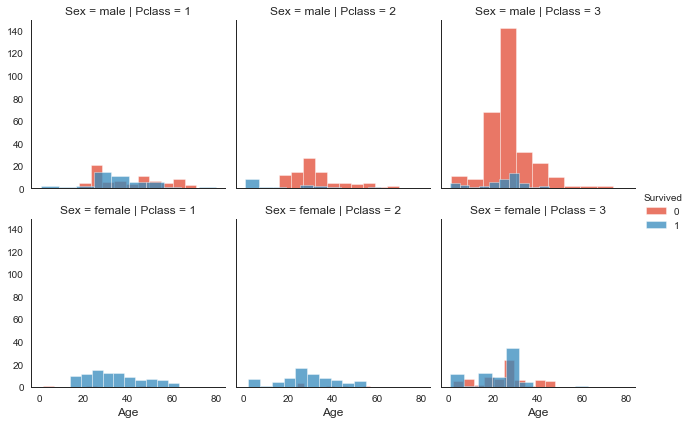

In [20]:
# 先创建网格子图对象
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
# 在map函数中画图，映射给所有子图
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

#### sns: 热力图

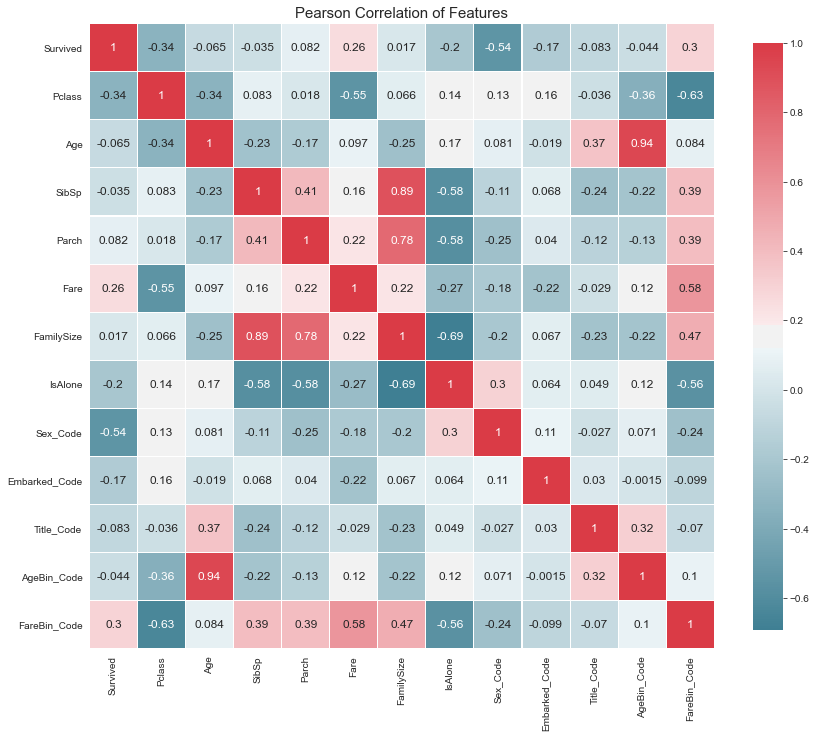

In [21]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

## 建模分析

### 预测算法选择

In [22]:
MLA = [
    #Ensemble Methods：集成学习，划分子样本，分别建模，融合结果
    
    ensemble.AdaBoostClassifier(),  # 默认采用决策树
    ensemble.BaggingClassifier(),  # 默认采用决策树
    ensemble.ExtraTreesClassifier(),  # 类似于随机森林
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),  # 随机森林分类器

    #Gaussian Processes： 高斯过程
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM：广义线性模型
    linear_model.LogisticRegressionCV(),  # 逻辑线性回归交叉验证 
    linear_model.PassiveAggressiveClassifier(),  # 被动攻击算法（在线学习）
    linear_model.RidgeClassifierCV(),  # 岭回归交叉验证
    linear_model.SGDClassifier(),  # 随机梯度下降分类器
    linear_model.Perceptron(),  # 感知机
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),  # 先验伯努利分布的NB - 适合样本特征是稀疏离散值
    naive_bayes.GaussianNB(),  # 先验高斯分布的NB - 适合样本特征大多是连续值
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),  # K近邻 
    
    #SVM：支持向量机 - 擅长二元分类
    svm.SVC(probability=True),  # probability - 是否采用概率估计
    svm.NuSVC(probability=True),  # 核支持向量机，可以控制向量个数
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),  # 线性判别分析
    discriminant_analysis.QuadraticDiscriminantAnalysis(),  # 二次判别分析

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()   # 梯度提升树，也是集成思想
    ]  # 建立将要使用的模型库



### 建模及预测结果

In [23]:
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
# run model 10x with 60/30 split intentionally leaving out 10%
# 交叉验证方法：运行十次，训练集与测试集占比6：3，留出10%数据。
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

# create table to compare MLA metrics
# 模型预测结果比较表：
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__ # 获取算法名称
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())  # 获取算法参数
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score = True)
    #data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])  # 记录每种算法的预测结果
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.84,0.83,0.04,0.08
21,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.89,0.83,0.06,0.11
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.83,0.83,0.05,0.06
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.90,0.83,0.05,0.27
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.87,0.82,0.05,0.11
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.90,0.82,0.05,0.01
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.90,0.82,0.06,0.15
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.89,0.82,0.07,0.03
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.90,0.82,0.06,0.01
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.85,0.81,0.07,0.01


### 模型对比可视化

Text(0, 0.5, 'Algorithm')

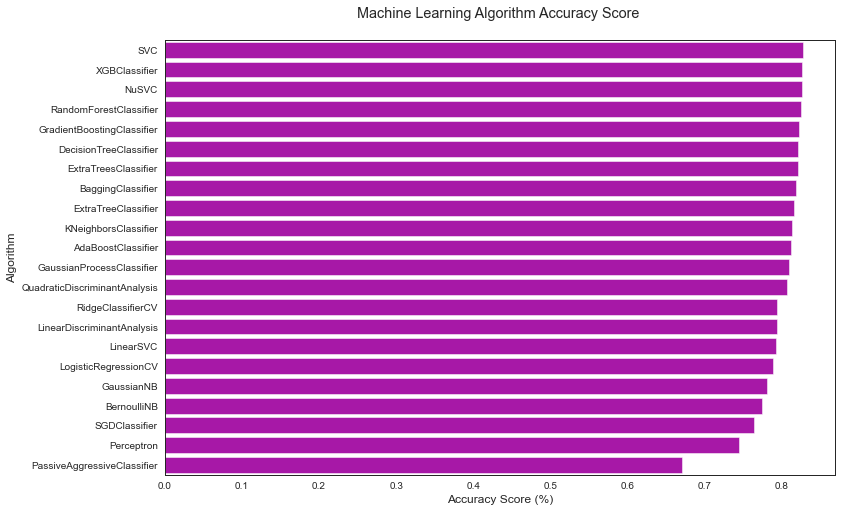

In [24]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### 简单模型构建及评估 

In [25]:
# 下面演示了一个“抛硬币”预测模型的构造、预测及评估过程
for index, row in data1.iterrows():   # iterrows() 返回元组(index, row)
    #random number generator: https://docs.python.org/2/library/random.html
    if random.random() > .5:     # Random float x, 0.0 <= x < 1.0    
        data1.loc[index, 'Random_Predict'] = 1 #predict survived/1
    else: 
        data1.loc[index, 'Random_Predict'] = 0#predict died/0
    

data1['Random_Score'] = 0 #assume prediction wrong

data1.loc[(data1['Survived'] == data1['Random_Predict']), 'Random_Score'] = 1 #set to 1 for correct prediction
print('Coin Flip Model Accuracy: {:.2f}%'.format(data1['Random_Score'].mean()*100))
print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(data1['Survived'], data1['Random_Predict'])*100))

Coin Flip Model Accuracy: 47.59%
Coin Flip Model Accuracy w/SciKit: 47.59%


In [26]:
# 下面构造一个简单的决策树模型
# 观察决策树节点
pivot_female = data1[data1.Sex=='female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n',pivot_female)

pivot_male = data1[data1.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print('\n\nSurvival Decision Tree w/Male Node: \n',pivot_male)

Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (-0.001, 7.91]     nan
                          (7.91, 14.454]     nan
                          (14.454, 31.0]    0.67
                          (31.0, 512.329]   1.00
                Q         (-0.001, 7.91]     nan
                          (7.91, 14.454]     nan
                          (14.454, 31.0]     nan
                          (31.0, 512.329]   1.00
                S         (-0.001, 7.91]     nan
                          (7.91, 14.454]     nan
                          (14.454, 31.0]    1.00
                          (31.0, 512.329]   0.96
        2       C         (-0.001, 7.91]     nan
                          (7.91, 14.454]    1.00
                          (14.454, 31.0]    1.00
                          (31.0, 512.329]   1.00
                Q         (-0.001, 7.91]     nan
                          (7.91, 14.454]    1.00
                          (14.454, 3

In [27]:
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #survived titles

    for index, row in df.iterrows():

        #Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        #Question 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)
           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model


#model data
Tree_Predict = mytree(data1)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}%\n'.format(metrics.accuracy_score(data1['Survived'], Tree_Predict)*100))


#Accuracy Summary Report with http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
#Where recall score = (true positives)/(true positive + false negative) w/1 being best:http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
#And F1 score = weighted average of precision and recall w/1 being best: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
print(metrics.classification_report(data1['Survived'], Tree_Predict))

Decision Tree Model Accuracy/Precision Score: 82.04%

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.68      0.75       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.82       891



Confusion matrix, without normalization
[[497  52]
 [108 234]]
Normalized confusion matrix
[[0.91 0.09]
 [0.32 0.68]]


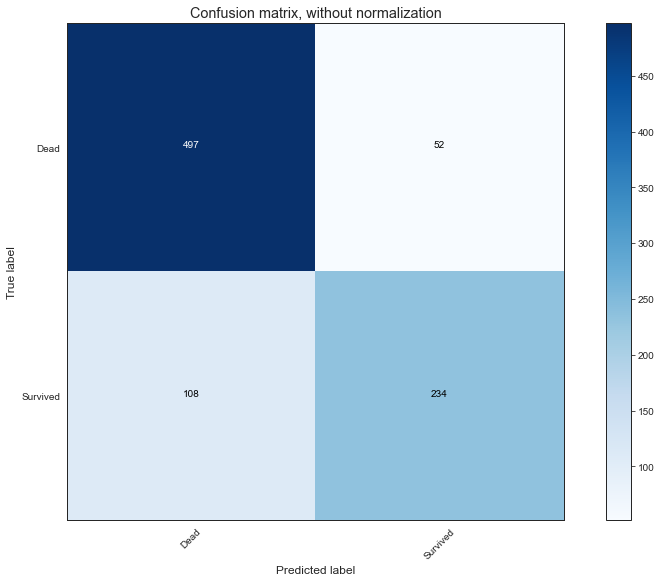

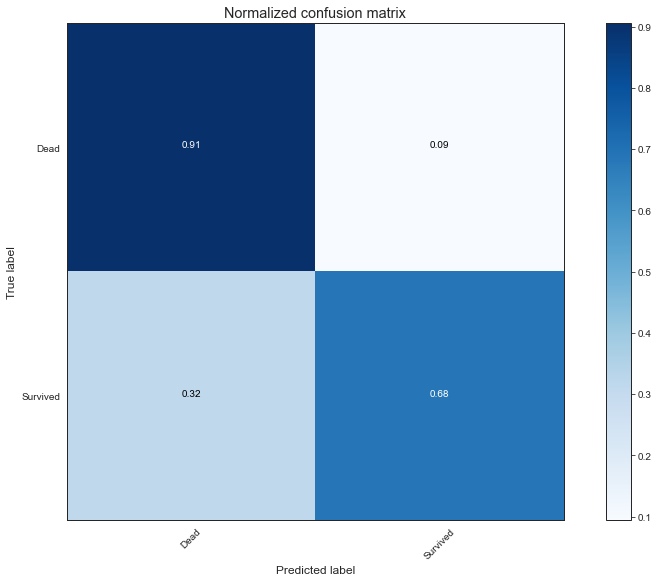

In [28]:
#Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix # 混淆矩阵
cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

### 调参

In [29]:
# 演示决策树模型的调参过程
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split)
dtree.fit(data1[data1_x_bin], data1[Target])

# cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(data1[data1_x_bin], data1[Target])

print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 0, 'splitter': 'best'}
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_random_state', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin 

### 特征选择

In [30]:
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#feature selection 特征选择
# RFECV（Recursive feature elimination + Cross Validation）: 递归特征消除（特征评级）+交叉验证（选择最佳数量特征）
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: +/- 5.57
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------


### 模型验证

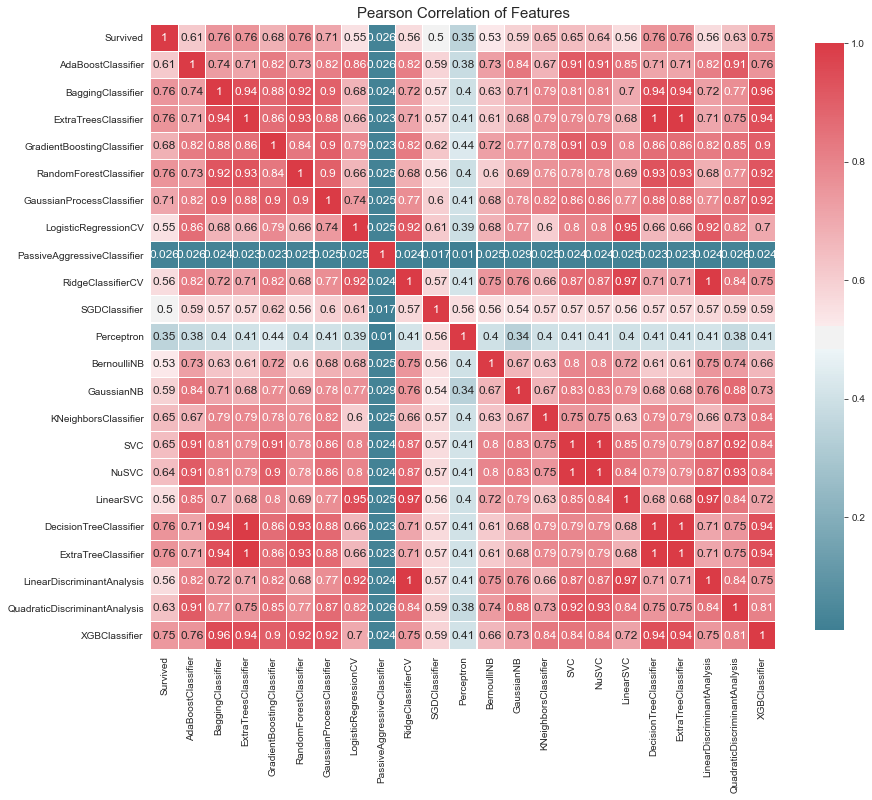

In [31]:
#不同算法比较
# MLA_predict
correlation_heatmap(MLA_predict)

#### 简单融合

In [32]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules（少数服从多数）
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities（加权投票）
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 82.16
Hard Voting Test w/bin score mean: 82.16
Hard Voting Test w/bin score 3*std: +/- 4.36
----------
Soft Voting Training w/bin score mean: 82.24
Soft Voting Test w/bin score mean: 82.24
Soft Voting Test w/bin score 3*std: +/- 4.13
----------


#### 超参调整 

In [33]:
#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 49.68 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 59.83 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 99.76 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 58.80 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 150.55 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 16.63 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_st

In [34]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)


#12/31/17 tuned with data1_x_bin
#The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 33.39 seconds.
#The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 30.28 seconds.
#The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 64.76 seconds.
#The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 34.35 seconds.
#The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 76.32 seconds.
#The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 6.01 seconds.
#The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'liblinear'} with a runtime of 8.04 seconds.
#The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.19 seconds.
#The best parameter for GaussianNB is {} with a runtime of 0.04 seconds.
#The best parameter for KNeighborsClassifier is {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'} with a runtime of 4.84 seconds.
#The best parameter for SVC is {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 29.39 seconds.
#The best parameter for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 46.23 seconds.
#Total optimization time was 5.56 minutes.

Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.35
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.30
----------
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 82.16
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.50
----------


#### 最终建模与结果提交

In [35]:
#prepare data for modeling
print(data_val.info())
print("-"*10)
#data_val.sample(10)



#handmade decision tree - submission score = 0.77990
data_val['Survived'] = mytree(data_val).astype(int)


#decision tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_dt = tree.DecisionTreeClassifier()
#submit_dt = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
#submit_dt.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_dt.best_params_) #Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
#data_val['Survived'] = submit_dt.predict(data_val[data1_x_bin])


#bagging w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77990
#submit_bc = ensemble.BaggingClassifier()
#submit_bc = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid= {'n_estimators':grid_n_estimator, 'max_samples': grid_ratio, 'oob_score': grid_bool, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_bc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_bc.best_params_) #Best Parameters:  {'max_samples': 0.25, 'n_estimators': 500, 'oob_score': True, 'random_state': 0}
#data_val['Survived'] = submit_bc.predict(data_val[data1_x_bin])


#extra tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_etc = ensemble.ExtraTreesClassifier()
#submit_etc = model_selection.GridSearchCV(ensemble.ExtraTreesClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_etc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_etc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_etc.predict(data_val[data1_x_bin])


#random foreset w/full dataset modeling submission score: defaults= 0.71291, tuned= 0.73205
#submit_rfc = ensemble.RandomForestClassifier()
#submit_rfc = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_rfc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_rfc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_rfc.predict(data_val[data1_x_bin])



#ada boosting w/full dataset modeling submission score: defaults= 0.74162, tuned= 0.75119
#submit_abc = ensemble.AdaBoostClassifier()
#submit_abc = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid={'n_estimators': grid_n_estimator, 'learning_rate': grid_ratio, 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_abc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_abc.best_params_) #Best Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}
#data_val['Survived'] = submit_abc.predict(data_val[data1_x_bin])


#gradient boosting w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77033
#submit_gbc = ensemble.GradientBoostingClassifier()
#submit_gbc = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid={'learning_rate': grid_ratio, 'n_estimators': grid_n_estimator, 'max_depth': grid_max_depth, 'random_state':grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_gbc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_gbc.best_params_) #Best Parameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 50, 'random_state': 0}
#data_val['Survived'] = submit_gbc.predict(data_val[data1_x_bin])

#extreme boosting w/full dataset modeling submission score: defaults= 0.73684, tuned= 0.77990
#submit_xgb = XGBClassifier()
#submit_xgb = model_selection.GridSearchCV(XGBClassifier(), param_grid= {'learning_rate': grid_learn, 'max_depth': [0,2,4,6,8,10], 'n_estimators': grid_n_estimator, 'seed': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_xgb.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_xgb.best_params_) #Best Parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0}
#data_val['Survived'] = submit_xgb.predict(data_val[data1_x_bin])


#hard voting classifier w/full dataset modeling submission score: defaults= 0.75598, tuned = 0.77990
#data_val['Survived'] = vote_hard.predict(data_val[data1_x_bin])
data_val['Survived'] = grid_hard.predict(data_val[data1_x_bin])


#soft voting classifier w/full dataset modeling submission score: defaults= 0.73684, tuned = 0.74162
#data_val['Survived'] = vote_soft.predict(data_val[data1_x_bin])
#data_val['Survived'] = grid_soft.predict(data_val[data1_x_bin])


#submit file
submit = data_val[['PassengerId','Survived']]
# submit.to_csv("../working/submit.csv", index=False)

print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
submit.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    418 non-null    int64   
 1   Pclass         418 non-null    int64   
 2   Name           418 non-null    object  
 3   Sex            418 non-null    object  
 4   Age            418 non-null    float64 
 5   SibSp          418 non-null    int64   
 6   Parch          418 non-null    int64   
 7   Ticket         418 non-null    object  
 8   Fare           418 non-null    float64 
 9   Cabin          91 non-null     object  
 10  Embarked       418 non-null    object  
 11  FamilySize     418 non-null    int64   
 12  IsAlone        418 non-null    int64   
 13  Title          418 non-null    object  
 14  FareBin        418 non-null    category
 15  AgeBin         418 non-null    category
 16  Sex_Code       418 non-null    int32   
 17  Embarked_Code  418 non-null    int3

,PassengerId,Survived
404,1296,0
182,1074,1
99,991,0
127,1019,1
250,1142,1
351,1243,0
129,1021,0
8,900,1
212,1104,0
350,1242,1
